In [511]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy import stats
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

In [512]:
df = pd.read_csv("clean_data.csv", index_col=0)
df

,required_age,price,relase_year,Violent,Adventure,RPG,Action,Sports,Simulation,Racing,...,Includes level editor,Co-op,Commentary available,Additional High-Quality Audio,Steam Cloud,Steam Workshop,mac,linux,windows,score
0,0,1379,2021,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0.955032
1,0,399,2021,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.733668
2,0,499,2021,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0.921053
3,0,5999,2022,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0.953191
4,0,799,2021,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.971429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,599,2017,0,0,1,1,0,0,0,...,0,0,0,0,1,0,1,1,1,0.921875
9996,0,1679,2020,0,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.660407
9997,0,4999,2020,0,0,1,1,1,0,0,...,0,1,1,0,1,0,0,0,1,0.677665
9998,0,1999,2017,0,1,1,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0.973799


# Correlation Distribution

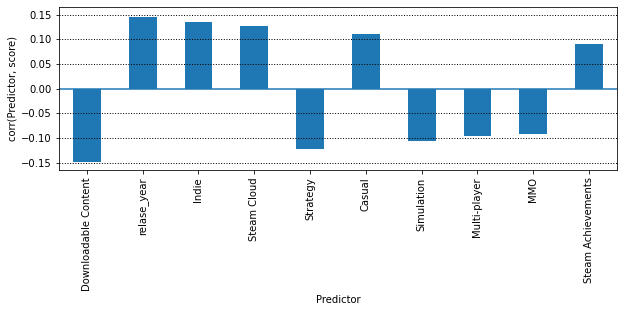

In [513]:
df.drop("Remote Play Together", axis=1, inplace=True)
plt.figure(figsize=(10,3))
plt.axhline(0)
for i in [-0.15, -0.1, -0.05, 0.05, 0.1, 0.15]:
    plt.axhline(i, color = "black", linestyle=':', linewidth = 1)

plt.xlabel("Predictor")
plt.ylabel("corr(Predictor, score)")
bars = bars = df.corr()['score'][df.corr()['score'].abs().sort_values(ascending=False).index][range(1,11)].plot(kind='bar')
plt.savefig('corr_dist.png', dpi=300, bbox_inches="tight")

# MLR

In [514]:
def find_predictors(df):
    
    # Sort by absolute correlation
    predictors = abs(df.corr()['score']).sort_values(ascending=False).drop("score")

    r2_max = 0
    i_max = 0

    # add variables until model is overfitting
    for i, col in enumerate(list(predictors.index)):
        trans= PowerTransformer()
        reg = LinearRegression()
        regression = TransformedTargetRegressor(regressor = reg, transformer = trans)
        X = df[predictors.index[:i+1]]
        X_train, X_test, y_train, y_test = train_test_split(X, df["score"], test_size=0.3, random_state=42)
        regression.fit(X_train, y_train)
        y_pred = regression.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2 > r2_max:
            r2_max = r2
            i_max = i+1

    # return predictors
    return predictors[0:i_max] 


In [518]:
# train again best model
predictors  = find_predictors(df)
X_train, X_test, y_train, y_test = train_test_split(df[list(predictors.index)], df["score"], test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

len(predictors), round(r2, 5), round(MSE, 5), round(explained_var,5)

(39, 0.11576, 0.02131, 0.11576)

## see which IVs have correlation higher than 0.5

In [515]:
corr = df.iloc[:,0:-1].corr()
high_corr1, high_corr2 = np.where(np.abs(corr)>0.5)
# get indicics of highly correlated features in feature matrix
A = []
for i in range(len(high_corr1)):
    if high_corr1[i]!=high_corr2[i]:
        A.append((high_corr1[i],high_corr2[i]))
        
# transform indices to names of columns, add to tuple together with correlation of the features
B = []
for i in range(len(A)):
    B.append((df.columns[A[i][0]],df.columns[A[i][1]], round(corr.iloc[A[i][0],A[i][1]],3)))
    

In [516]:
# transform indices to names of columns, add to tuple together with correlation of the features
B = []
for i in range(len(A)):
    B.append((df.columns[A[i][0]],df.columns[A[i][1]], round(corr.iloc[A[i][0],A[i][1]],3)))
    

In [517]:
B

[('Nudity', 'Sexual Content', 0.572),
 ('Sexual Content', 'Nudity', 0.572),
 ('Multi-player', 'PvP', 0.632),
 ('Multi-player', 'Shared/Split Screen', 0.505),
 ('Multi-player', 'Co-op', 0.653),
 ('LAN Co-op', 'LAN PvP', 0.621),
 ('PvP', 'Multi-player', 0.632),
 ('LAN PvP', 'LAN Co-op', 0.621),
 ('Shared/Split Screen', 'Multi-player', 0.505),
 ('Includes level editor', 'Steam Workshop', 0.507),
 ('Co-op', 'Multi-player', 0.653),
 ('Steam Workshop', 'Includes level editor', 0.507),
 ('mac', 'linux', 0.654),
 ('linux', 'mac', 0.654)]

## Histograms conditioned on MMO, Indie and release_year

(array([2.04185809e-03, 2.04185809e-03, 3.26697295e-02, 3.67534456e-02,
        4.69627361e-02, 9.39254722e-02, 1.49055641e-01, 1.73557938e-01,
        2.53190403e-01, 3.04236856e-01, 5.10464523e-01, 6.55436447e-01,
        8.90250128e-01, 1.19244513e+00, 1.61919347e+00, 2.20316488e+00,
        2.66870852e+00, 3.15262889e+00, 3.63450740e+00, 2.37876468e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

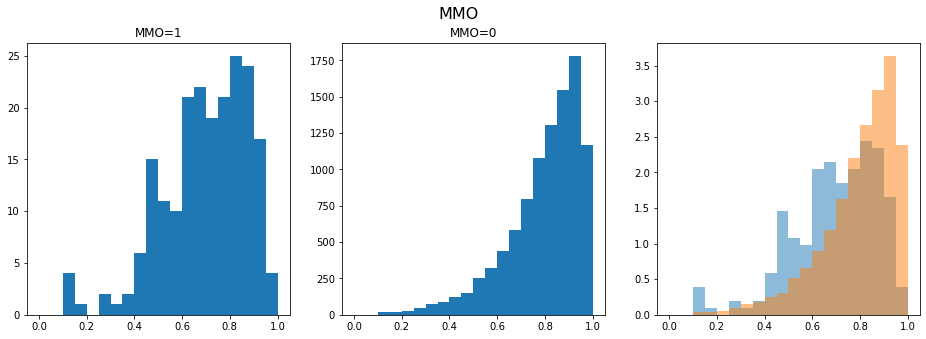

In [519]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('MMO', fontsize=16)
ax1.hist(df.loc[df['MMO'] == 1]["score"],bins)
ax2.hist(df.loc[df["MMO"] == 0]["score"],bins)
ax1.set_title("MMO=1")
ax2.set_title("MMO=0")
ax3.hist(df.loc[df['MMO'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df["MMO"] == 0]["score"],bins, density=True, alpha=0.5)

eyeballing the plot shows already that MMOs are worse rated than non-MMOs. This goes against our prediction that that MMOs are better rated, as playing togehter is supposedly more fun (explanation could be bugs, toxic gamers etc.)

confirm with Whitney U-Test:

In [520]:
stats.mannwhitneyu(df.loc[df["MMO"] == 0]["score"], df.loc[df['MMO'] == 1]["score"],alternative="less")

MannwhitneyuResult(statistic=1368567.0, pvalue=1.0)

whitneyu provides evidence that distribution of MMO=1 is NOT higher than distribution of MMO=0.

(array([2.23588597e-03, 2.23588597e-03, 2.90665176e-02, 2.45947457e-02,
        3.13024036e-02, 7.82560089e-02, 1.20737842e-01, 1.38624930e-01,
        2.28060369e-01, 2.90665176e-01, 4.38233650e-01, 6.19340414e-01,
        9.03297932e-01, 1.20290665e+00, 1.62101733e+00, 2.18893236e+00,
        2.70542202e+00, 3.21296814e+00, 3.74734489e+00, 2.41475685e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

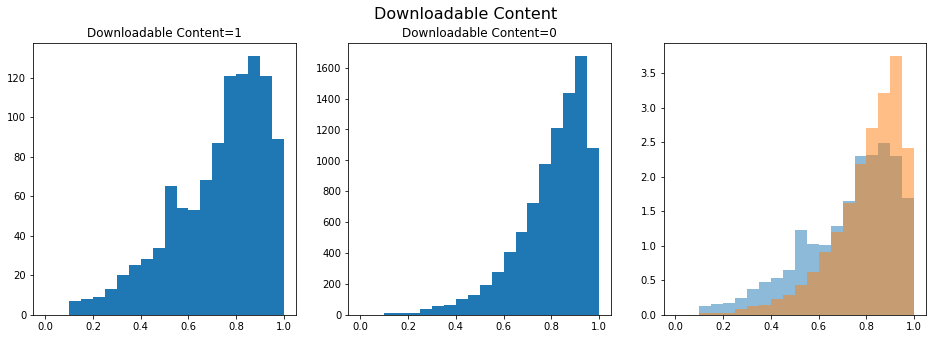

In [521]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('Downloadable Content', fontsize=16)
ax1.hist(df.loc[df['Downloadable Content'] == 1]["score"],bins)
ax2.hist(df.loc[df['Downloadable Content'] == 0]["score"],bins)
ax1.set_title("Downloadable Content=1")
ax2.set_title("Downloadable Content=0")
ax3.hist(df.loc[df['Downloadable Content'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df['Downloadable Content'] == 0]["score"],bins, density=True, alpha=0.5)

In [522]:
#stats.mannwhitneyu(df.loc[df['Downloadable Content'] == 0]["score"], df.loc[df['Downloadable Content'] == 1]["score"],alternative="less")

(array([0.00516529, 0.00516529, 0.08780992, 0.06198347, 0.08780992,
        0.15495868, 0.20144628, 0.25309917, 0.30475207, 0.4803719 ,
        0.73863636, 0.79028926, 1.07438017, 1.24483471, 1.70454545,
        2.23140496, 2.74793388, 3.01136364, 3.00619835, 1.80785124]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

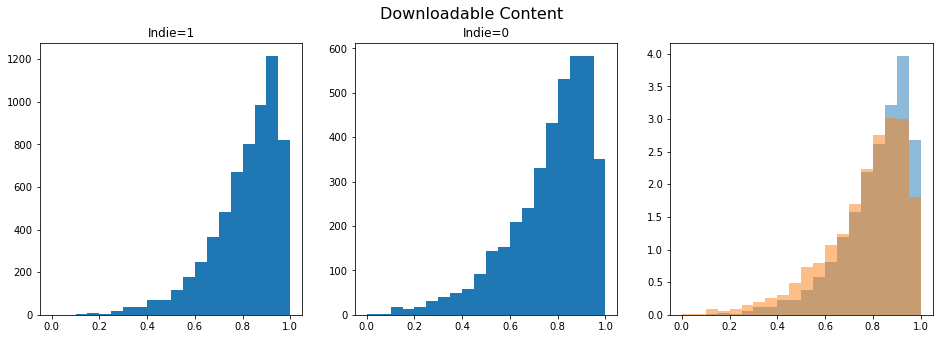

In [523]:
bins = np.linspace(0,1,21)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16, 5))
fig.suptitle('Downloadable Content', fontsize=16)
ax1.hist(df.loc[df['Indie'] == 1]["score"],bins)
ax2.hist(df.loc[df['Indie'] == 0]["score"],bins)
ax1.set_title('Indie=1')
ax2.set_title('Indie=0')
ax3.hist(df.loc[df['Indie'] == 1]["score"],bins, density=True, alpha=0.5)
ax3.hist(df.loc[df['Indie'] == 0]["score"],bins, density=True, alpha=0.5)

In [524]:
stats.mannwhitneyu(df.loc[df['Indie'] == 0]["score"], df.loc[df['Indie'] == 1]["score"], alternative="less")

MannwhitneyuResult(statistic=10105239.0, pvalue=3.482767775659832e-36)

Whitneyu provides evidence that Indie games are better than non-indie games

In [525]:
#set(df["relase_year"])

In [526]:
A = np.zeros(len(set(df["relase_year"])))
for i in range(len(set(df["relase_year"]))):
    A[i] = np.mean(df.loc[lambda df: df.relase_year == 1998+i,"score"])
    

Text(0.5, 1.0, 'average game-score by release year')

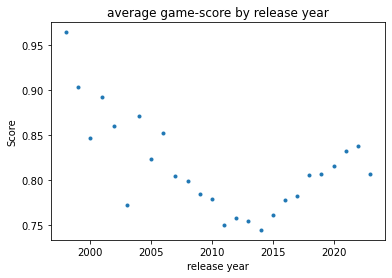

In [527]:
plt.plot(A,".")
plt.ylabel("Score")
plt.xlabel("release year")
plt.xticks([2,7,12,17,22],labels=["2000","2005", "2010", "2015", "2020"])
plt.title("average game-score by release year")

Dem anschein nach scheinen spiele mal besser (bewertet) gewesen zu sein. Der Plot ist Allerdings mit Vorsicht zu genießen,
z.B. für die Jahre 1998,1999 sind nur 1-2 Spiele im Datensatz.

# try comparing all histograms conditioned on all categorical variables:

In [528]:
#for idx in range(1, len(df.columns)-1):
#    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 5))
#    fig.suptitle(df.columns[idx], fontsize=16)
#    ax1.hist(df.loc[df.iloc[:,idx] == 1]["score"],bins)
#    ax2.hist(df.loc[df.iloc[:,idx] == 0]["score"],bins)
#    ax1.set_title(df.columns[idx]+"=1")
#    ax2.set_title(df.columns[idx]+"=0")

# standardize data before using it as NN input

In [529]:
df_stand = df.copy(deep=True)

In [530]:
age = df["required_age"]

In [531]:
df_stand["required_age"] = (age-np.mean(age))/np.std(age)

In [532]:
price = np.array(df["price"]).reshape(-1)

In [533]:
df_stand["price"] = (price-np.mean(price))/np.std(price)

In [534]:
year = df["relase_year"]

In [535]:
df_stand["relase_year"] = (year-np.mean(year))/np.std(year)

In [536]:
df_stand["score"]

0       0.955032
1       0.733668
2       0.921053
3       0.953191
4       0.971429
          ...   
9995    0.921875
9996    0.660407
9997    0.677665
9998    0.973799
9999    0.601449
Name: score, Length: 10000, dtype: float64

In [537]:
#score = df["score"]

In [538]:
#df_stand["score"] = (score-np.mean(score))/np.std(score)

In [539]:
#df_stand

# try achieving less error with NN

In [540]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
import datetime

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))

In [ ]:
class SteamData(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.data_size = len(self.df)
        self.num_variables = len(self.df.columns[0:-1])
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        IVs = torch.from_numpy(np.array(self.df.iloc[idx,0:-1],dtype=np.double))
        target = torch.from_numpy(np.array(self.df.loc[idx,"score"], dtype=np.double))
        
        sample = (IVs,target)
        
        #if self.transform:
        #    sample = self.transform(sample)
        return sample

In [ ]:
Dataloader_steam = SteamData(df_stand)

In [ ]:
BATCHSIZE = 64

In [ ]:
generator=torch.Generator().manual_seed(42)

In [ ]:
train_size = int(0.7 * len(df_stand))
test_size = len(df_stand) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(Dataloader_steam, [train_size, test_size], generator =generator)

In [ ]:
SteamData_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE,
shuffle=True)

SteamData_val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE,
shuffle=False)

In [ ]:
#for IVs, score in SteamData_train_loader:
#    print(IVs.shape) 
#    print(score.shape)

In [ ]:
len(df.columns)

54

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.leaky_relu(self.lin1(x))
        out = F.leaky_relu(self.lin2(out))
        out = F.leaky_relu(self.lin3(out))
        out = F.sigmoid(self.lin4(out))
        return out

In [ ]:
class NN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.sigmoid(self.lin1(x))
        out = F.sigmoid(self.lin2(out))
        out = F.sigmoid(self.lin3(out))
        out = F.sigmoid(self.lin4(out))
        return out

In [ ]:
class NN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,256)
        self.lin2 = nn.Linear(256,256)
        self.lin3 = nn.Linear(256,256)
        self.lin4 = nn.Linear(256,1)
        
    def forward(self,x):
        out = F.tanh(self.lin1(x))
        out = F.tanh(self.lin2(out))
        out = F.tanh(self.lin3(out))
        out = F.tanh(self.lin4(out))
        return out

In [ ]:
class NN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(53,128)
        self.lin2 = nn.Linear(128,256)
        self.lin3 = nn.Linear(256,128)
        self.lin4 = nn.Linear(128,1)
        
    def forward(self,x):
        out = F.tanh(self.lin1(x))
        out = F.tanh(self.lin2(out))
        out = F.tanh(self.lin3(out))
        out = F.tanh(self.lin4(out))
        return out

In [ ]:
model = NN()

In [ ]:
model = model.to(device=device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
model.train()
n_epochs = 20

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_train = np.array(n_epochs)
    loss_val = np.array(n_epochs)
    for epoch in range(1,n_epochs+1):
        model.train()
        total_loss_train = 0
        total_loss_val = 0
        for IV, score in train_loader:
            IV = IV.to(device=device)
            score = score.to(device=device)
            #print(score)
            outputs = model(IV)
            #print(outputs)
            #print(outputs.shape)
            loss_train = loss_fn(outputs.flatten(), score)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
            total_loss_train+=loss_train
        
        for IV, score in val_loader:
            model.eval()
            with torch.no_grad():
                IV = IV.to(device=device)
                score = score.to(device=device)
                outputs = model(IV)
                #print(outputs)
                loss_val = loss_fn(outputs.flatten(), score)
                
                total_loss_val+=loss_val
       
            
            

        if epoch ==1 or epoch % 1 == 0:
            print("{} Epoch {}, Training loss {}, Validation Loss: {}".format(
            datetime.datetime.now(), epoch,
            total_loss_train/ len(train_loader), total_loss_val/len(val_loader)))

In [ ]:
training_loop(n_epochs, optimizer, model, loss_fn, SteamData_train_loader, SteamData_val_loader)

C:\Users\Marco\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2023-01-27 17:41:45.873686 Epoch 1, Training loss 0.061748960867782914, Validation Loss: 0.025326012901554243
2023-01-27 17:41:48.582411 Epoch 2, Training loss 0.024216764205516085, Validation Loss: 0.023372078734407588
2023-01-27 17:41:51.155385 Epoch 3, Training loss 0.022687218185443597, Validation Loss: 0.022414028724833456
2023-01-27 17:41:53.649102 Epoch 4, Training loss 0.02192177071100071, Validation Loss: 0.02181533442262494
2023-01-27 17:41:56.089336 Epoch 5, Training loss 0.021227665951823103, Validation Loss: 0.021365788219348408
2023-01-27 17:41:58.640584 Epoch 6, Training loss 0.020757355353865716, Validation Loss: 0.02100640561444677
2023-01-27 17:42:01.127019 Epoch 7, Training loss 0.0203806899753596, Validation Loss: 0.02080571918549711
2023-01-27 17:42:03.726410 Epoch 8, Training loss 0.02005404111702443, Validation Loss: 0.020712521709268968
2023-01-27 17:42:06.166586 Epoch 9, Training loss 0.019884125073109347, Validation Loss: 0.02059524019423685
2023-01-27 17:42:0

In [ ]:
len(df.columns)

54

## check residual plot for NN

In [ ]:
test_samples = np.zeros((len(SteamData_val_loader.dataset),53))

In [ ]:
test_samples_score = np.zeros(len(SteamData_val_loader.dataset))

In [ ]:
idx=0
for IV,score in SteamData_val_loader:
    #print(IV.shape[0])
    #IV.shape[0]
    test_samples[idx:idx+IV.shape[0]] = IV
    test_samples_score[idx:idx+IV.shape[0]] = score
    idx=idx+IV.shape[0]

In [ ]:
test_samples = (torch.from_numpy(test_samples)).to(device)

In [ ]:
with torch.no_grad():
    y_pred_NN = model(test_samples)

C:\Users\Marco\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
#y_pred_NN[:100]

In [ ]:
test_samples_score

array([0.88461538, 0.78181818, 0.79049296, ..., 0.92041522, 0.84759456,
       0.83950617])

In [ ]:
y_pred_NN 

tensor([[0.8361],
        [0.6914],
        [0.8036],
        ...,
        [0.8297],
        [0.8246],
        [0.8930]], device='cuda:0', dtype=torch.float64)

In [ ]:
explained_variance_score(test_samples_score,y_pred_NN.cpu().numpy())

0.16647645455064763

In [ ]:
y_pred_NN.cpu().numpy().reshape(-1)

array([0.83610838, 0.69138183, 0.80360951, ..., 0.82970871, 0.82460898,
       0.89304716])

In [ ]:
(y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score).shape

(3000,)

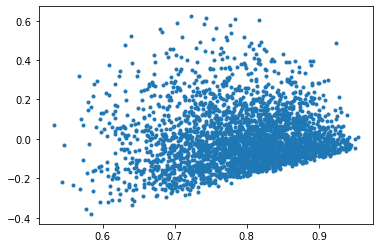

In [ ]:
plt.plot(y_pred_NN.cpu().numpy().reshape(-1) ,y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score,".")

### predicted vs actual values

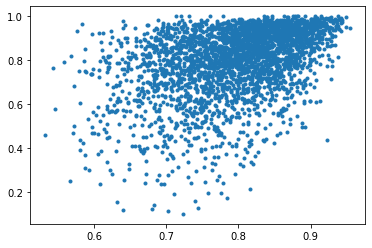

In [ ]:
plt.plot(y_pred_NN.cpu().numpy(),test_samples_score,".")

# plot difference between regression and NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[best_fit_indices_min[1]]],df["score"] , test_size=0.3, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
explained_var = explained_variance_score(y_test, y_pred)
MSE = mean_squared_error(y_pred, y_test)

In [ ]:
explained_var, MSE

(0.12119583473834483, 0.021182211904347804)

Text(0.5, 0, 'residuals/erros')

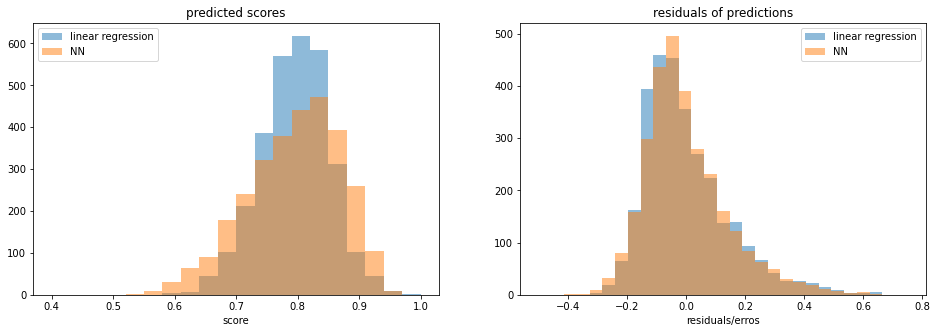

In [ ]:
bins = np.linspace(0.4,1,21)
bins2 = np.linspace(-0.5,0.75,30)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 5))
ax1.hist(y_pred, bins, alpha=0.5, label="linear regression")
ax1.hist(y_pred_NN.cpu().numpy().reshape(-1), bins, alpha=0.5, label="NN")
ax1.legend()
ax1.set_title("predicted scores")
ax1.set_xlabel("score")
ax2.hist(y_pred-y_test, bins2, alpha=0.5, label="linear regression")
ax2.hist(y_pred_NN.cpu().numpy().reshape(-1)- test_samples_score, bins2, alpha=0.5, label="NN")
ax2.legend()
ax2.set_title("residuals of predictions")
ax2.set_xlabel("residuals/erros")